In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train'])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=4)

class_names = train_set.classes

dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_set), 'test': len(test_set)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


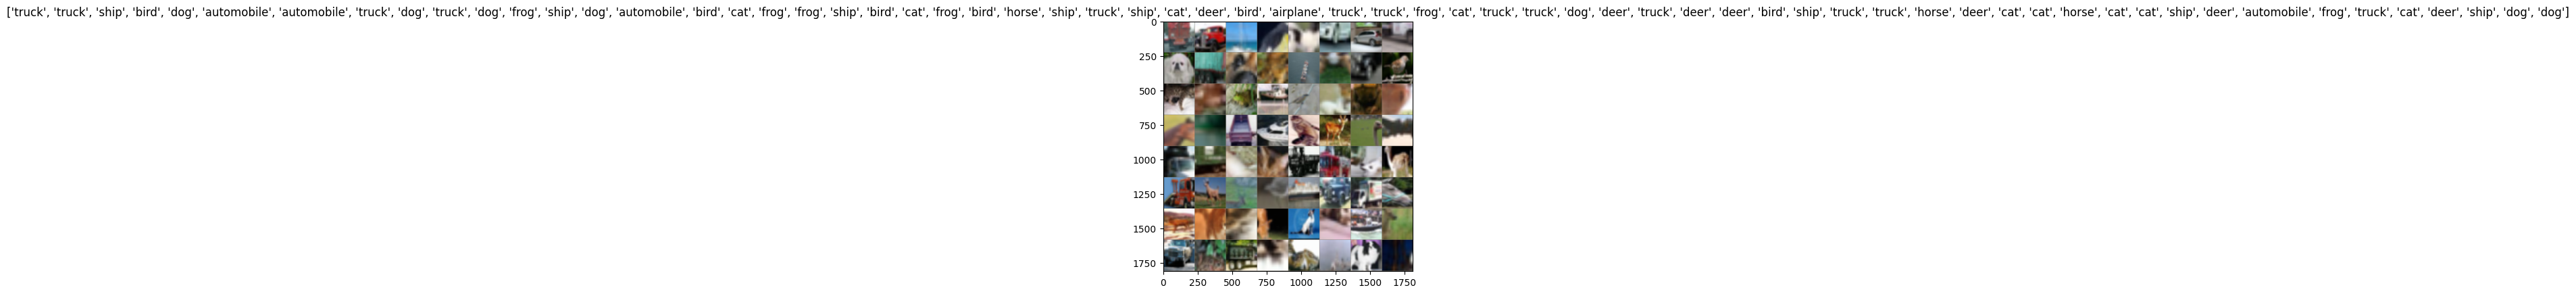

In [ ]:
import numpy as np
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs,classes=next(iter(dataloaders['train']))
out=torchvision.utils.make_grid(inputs)

imshow(out,title=[class_names[x] for x in classes])

In [ ]:
import time
import copy
import torch

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)


            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
googlenet=models.googlenet(pretrained=True)

num_features=googlenet.fc.in_features
googlenet.fc=nn.Linear(num_features,10)
googlenet=googlenet.to(device)

criterion=nn.CrossEntropyLoss()

optimizer=optim.SGD(googlenet.parameters(),lr=0.001,momentum=0.9)

exp_lr_scheduler=lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)

model_gn = train_model(googlenet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
--------------------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 1.2109 Acc: 0.5974
test Loss: 0.4147 Acc: 0.8650

Epoch 1/9
--------------------
train Loss: 0.7307 Acc: 0.7488
test Loss: 0.2936 Acc: 0.9012

Epoch 2/9
--------------------
train Loss: 0.6429 Acc: 0.7785
test Loss: 0.2465 Acc: 0.9149

Epoch 3/9
--------------------
train Loss: 0.5803 Acc: 0.7985
test Loss: 0.2152 Acc: 0.9252

Epoch 4/9
--------------------
train Loss: 0.5518 Acc: 0.8085
test Loss: 0.1983 Acc: 0.9324

Epoch 5/9
--------------------
train Loss: 0.5133 Acc: 0.8227
test Loss: 0.1874 Acc: 0.9349

Epoch 6/9
--------------------
train Loss: 0.5047 Acc: 0.8260
test Loss: 0.1820 Acc: 0.9386

Epoch 7/9
--------------------
train Loss: 0.5033 Acc: 0.8267
test Loss: 0.1803 Acc: 0.9378

Epoch 8/9
--------------------
train Loss: 0.4966 Acc: 0.8292
test Loss: 0.1802 Acc: 0.9374

Epoch 9/9
--------------------
train Loss: 0.4945 Acc: 0.8295
test Loss: 0.1774 Acc: 0.9392

Training complete in 37m 25s
Best test Acc: 0.939200


In [ ]:
torch.save(model_gn.state_dict(), "model.pth")
model_gn.load_state_dict(torch.load("model.pth"))
